# Recomendation system aproch comparatives

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.append('../lib')

from callback import MetricsPlotter
from data import InMemoryDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add, Activation, Lambda
from tensorflow.keras.layers import Concatenate, Dense, Dropout

## Prepare data

In [3]:
DATESET_PATH = '../data/movie-lens'

In [4]:
ratings = pd.read_csv(f'{DATESET_PATH}/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies = pd.read_csv(f'{DATESET_PATH}/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
top_users.head()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: rating, dtype: int64

In [7]:
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_movies.head()

movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64

In [8]:
top_r = ratings.join(top_users, rsuffix='_u_t_r', how='inner', on='userId')
top_r.head()

,userId,movieId,rating,timestamp,rating_u_t_r
10360,68,1,2.5,1158531426,1260
10361,68,2,2.5,1158532776,1260
10362,68,3,2.0,1158533415,1260
10363,68,5,2.0,1158533624,1260
10364,68,6,4.0,1158532058,1260


In [9]:
top_r = top_r.join(top_movies, rsuffix='_m_t_r', how='inner', on='movieId')
top_r.head()

,userId,movieId,rating,timestamp,rating_u_t_r,rating_m_t_r
10360,68,1,2.5,1158531426,1260,215
26092,182,1,4.0,1063289621,977,215
36374,249,1,4.0,1347317775,1046,215
39229,274,1,4.0,1171410158,1346,215
42114,288,1,4.5,1054568869,1055,215


In [10]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [11]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [12]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

X

array([[   0,    0],
       [   0,    2],
       [   0,    5],
       ...,
       [ 609, 9444],
       [ 609, 9445],
       [ 609, 9485]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70585, 2), (30251, 2), (70585,), (30251,))

## Colavorative filtering: Factorization Matix

In [14]:
def create_recommender_v1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(
        n_users, 
        n_factors, 
        embeddings_initializer='he_normal',
        embeddings_regularizer=l2(1e-6)
    )(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(
        n_movies, 
        n_factors, 
        embeddings_initializer='he_normal',
        embeddings_regularizer=l2(1e-6)
    )(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])

    model = Model(inputs=[user, movie], outputs=x)
    
    opt = Adam(lr=0.001)
    
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [15]:
batch_size=64

def to_input(X, y): return [X[:, 0], X[:, 1]], y

training_generator = InMemoryDataGenerator(X_train, y_train, batch_size, shuffle=True, to_input=to_input)
validation_generator = InMemoryDataGenerator(X_test, y_test, batch_size=2000, shuffle=True, to_input=to_input)

callbacks=[
     MetricsPlotter(
         validation_generator=validation_generator, 
         metrics_names=['loss'],
         plot_interval=50,  
         evaluate_interval=60,  
         batch_size=batch_size
     )
]

In [16]:
model = create_recommender_v1(
    n_users, 
    n_movies, 
    n_factors=50
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

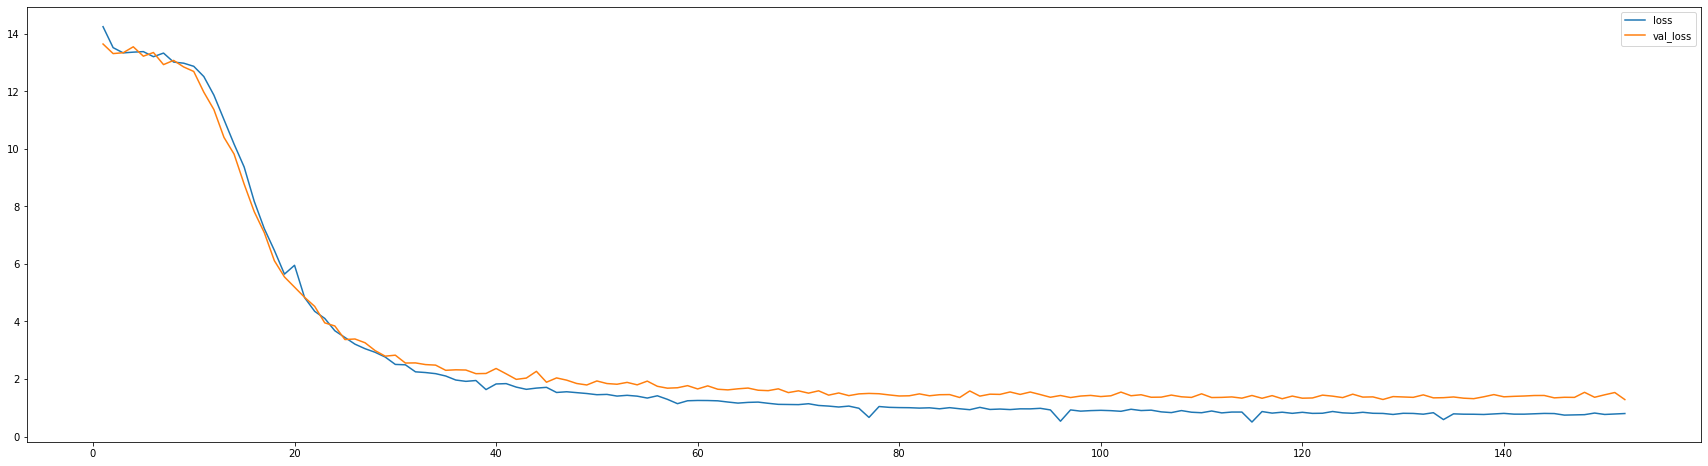

1102/1102 [==============================] - 11s 10ms/step - loss: 0.9375 - val_loss: 1.3793


In [17]:
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    use_multiprocessing=True,
    workers=8,
    epochs=8,
    verbose=1, 
    callbacks=callbacks
)

## Colavorative filtering: Factorization Matix + Biases

In [18]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def create_recommender_v2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [19]:
model = create_recommender_v2(
    n_users, 
    n_movies, 
    n_factors=50,
    min_rating=min_rating, 
    max_rating=max_rating
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

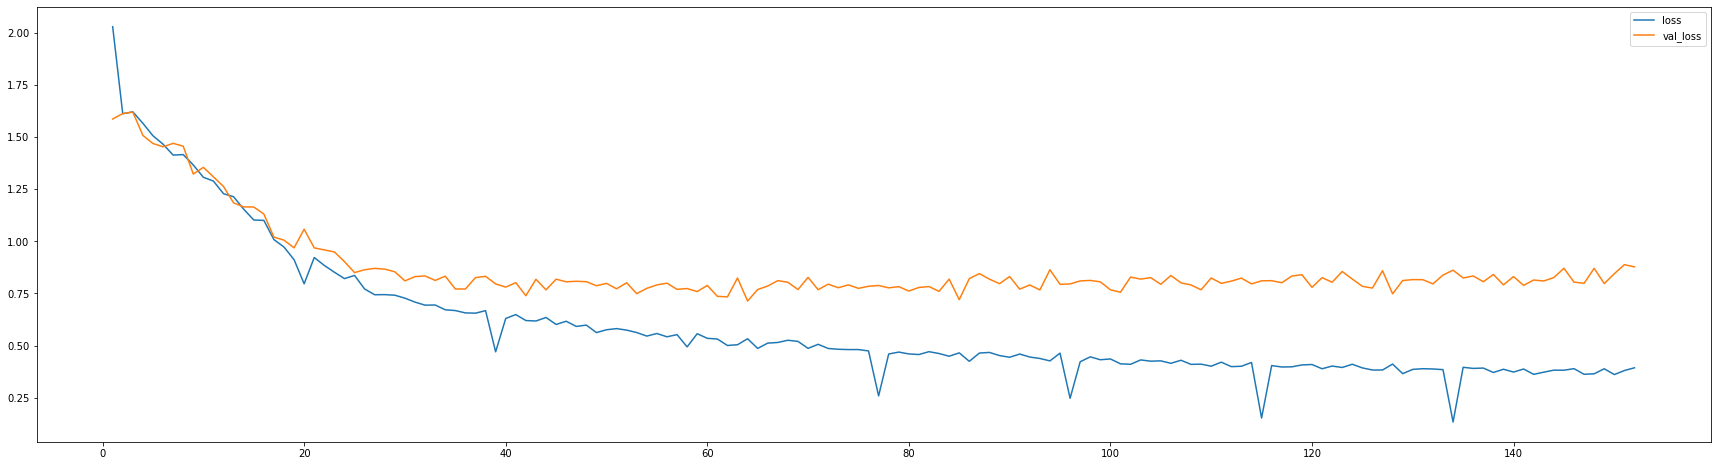

1102/1102 [==============================] - 11s 10ms/step - loss: 0.5833 - val_loss: 0.8344


In [20]:
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    use_multiprocessing=True,
    workers=8,
    epochs=8,
    verbose=1, 
    callbacks=callbacks
)

## Colavorative filtering: Deep Neural Network

In [21]:
def create_recommender_v3(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [22]:
model = create_recommender_v2(
    n_users, 
    n_movies, 
    n_factors=50,
    min_rating=min_rating, 
    max_rating=max_rating
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        30500       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        486200      input_6[0][0]                    
____________________________________________________________________________________________

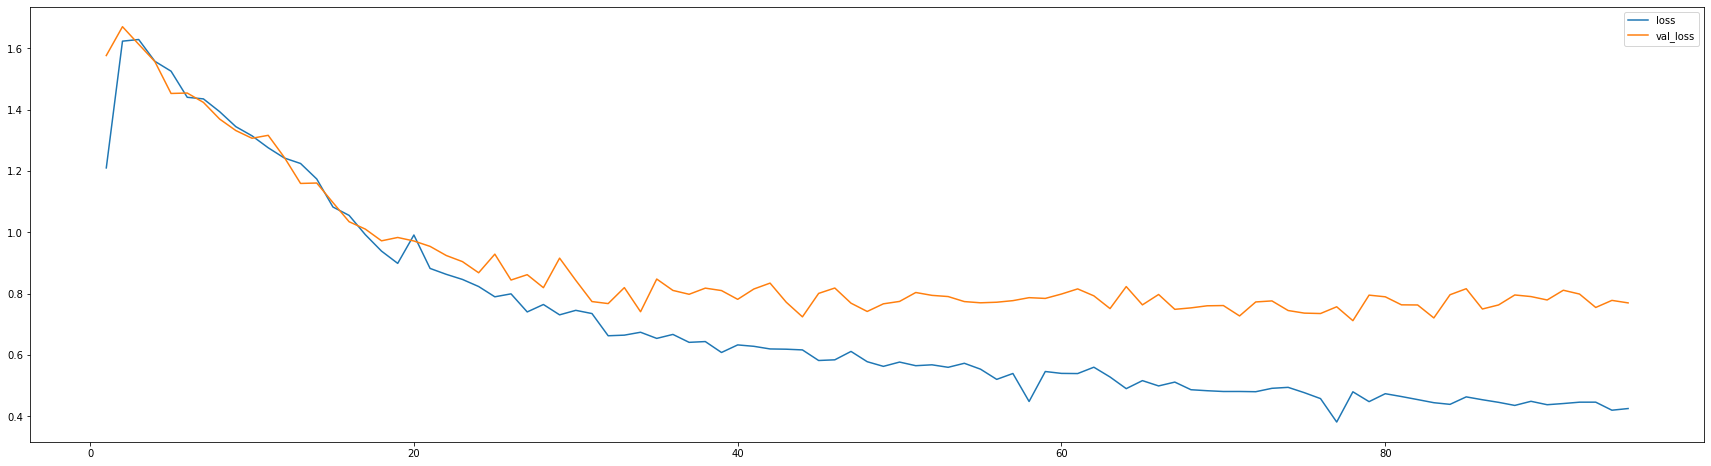

1102/1102 [==============================] - 10s 9ms/step - loss: 0.5573 - val_loss: 0.7809


In [23]:
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    use_multiprocessing=True,
    workers=8,
    epochs=5,
    verbose=1, 
    callbacks=callbacks
)

## Colavorative filtering: Wide & Deep